# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

## Unrolled version

In [2]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(0.03))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=6.802e-01; beta=1.442e-02

***results: Performance of L using unrolled is better than AccAltproj but not IRCUR***

In [3]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [4]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))

In [5]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-03, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est)

[Parameter containing:
tensor(6.990e-01, requires_grad=True), Parameter containing:
tensor(2.931e-02, requires_grad=True)]
Epoch 1/5 at cost=1.2042074282181403e-10
[Parameter containing:
tensor(6.981e-01, requires_grad=True), Parameter containing:
tensor(2.864e-02, requires_grad=True)]
Epoch 1/5 at cost=9.537343137466792e-11
[Parameter containing:
tensor(6.973e-01, requires_grad=True), Parameter containing:
tensor(2.801e-02, requires_grad=True)]
Epoch 1/5 at cost=6.360258153481624e-11
[Parameter containing:
tensor(6.965e-01, requires_grad=True), Parameter containing:
tensor(2.742e-02, requires_grad=True)]
Epoch 1/5 at cost=5.486560858414258e-11
[Parameter containing:
tensor(6.957e-01, requires_grad=True), Parameter containing:
tensor(2.686e-02, requires_grad=True)]
Epoch 1/5 at cost=5.390005455851998e-11
[Parameter containing:
tensor(6.950e-01, requires_grad=True), Parameter containing:
tensor(2.633e-02, requires_grad=True)]
Epoch 1/5 at cost=8.565671089089122e-11
[Parameter containing

#### Evaluating unrolled network on train dataset

In [6]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

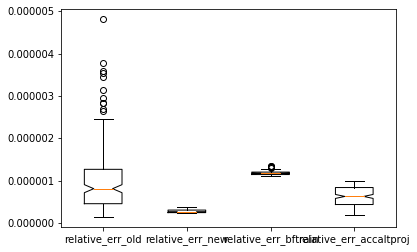

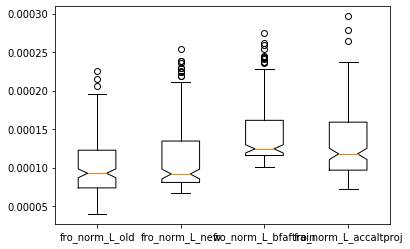

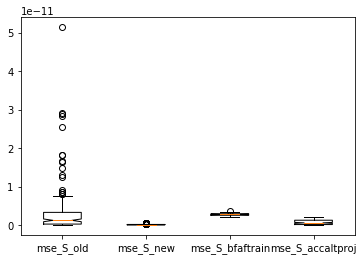

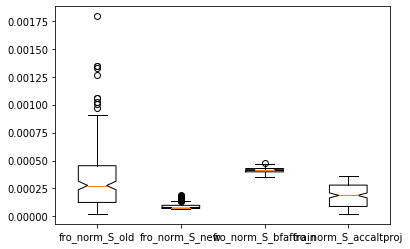

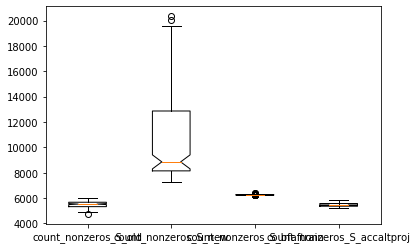

In [7]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [8]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  2.1378958421334803e-26
fro_norm_L_new, fro_norm_L_old:  0.9987450734598361
mse_S_new, mse_S_old:  2.7777384976442237e-10
fro_norm_S_new, fro_norm_S_old:  1.839445096520796e-22
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.6838798340233109e-49
fro_norm_L_new, fro_norm_L_accaltproj:  0.00016160869063894435
mse_S_new, mse_S_accaltproj:  2.34020991394812e-26
fro_norm_S_new, fro_norm_S_accaltproj:  3.8363964117624533e-26
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  2.910034292172676e-214
fro_norm_L_new, fro_norm_L_bftrain:  9.855642231055816e-10
mse_S_new, mse_S_bftrain:  7.607753758182544e-173
fro_norm_S_new, fro_norm_S_bftrain:  2.0375558147460137e-180
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


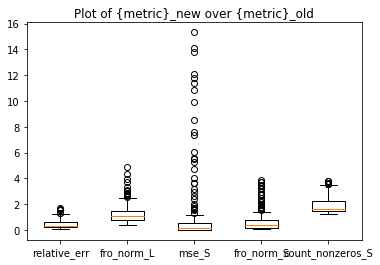

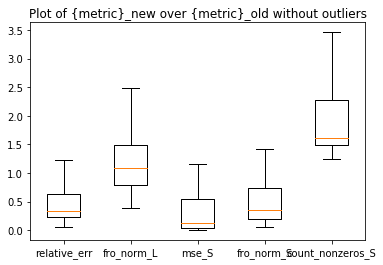

relative_err: 6/180 outliers
fro_norm_L: 14/180 outliers
mse_S: 30/180 outliers
fro_norm_S: 23/180 outliers
count_nonzeros_S: 8/180 outliers


In [9]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [10]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  1.8594204391138628e-44
fro_norm_L:  0.998963257420345
mse_S:  5.891434987588195e-26
fro_norm_S:  5.891633457122146e-26
count_nonzeros_S:  1.0


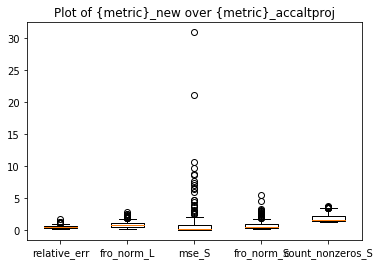

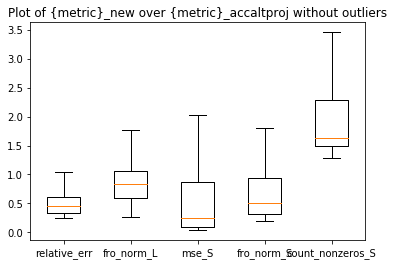

relative_err: 9/180 outliers
fro_norm_L: 18/180 outliers
mse_S: 24/180 outliers
fro_norm_S: 18/180 outliers
count_nonzeros_S: 9/180 outliers


In [11]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [12]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  6.484196052644797e-62
fro_norm_L:  0.08378569188445431
mse_S:  0.8921330902157979
fro_norm_S:  0.0009337064161494566
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [13]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest.append((L0, S0))

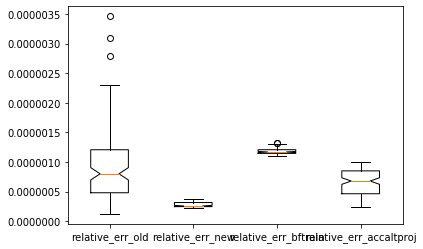

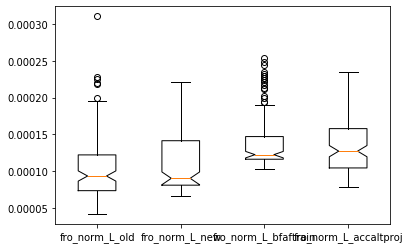

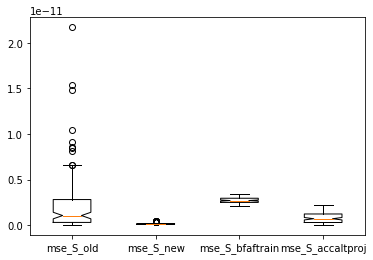

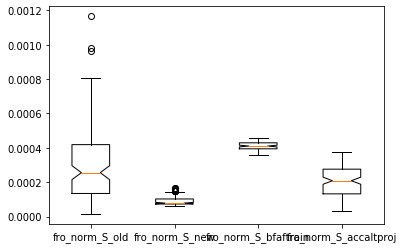

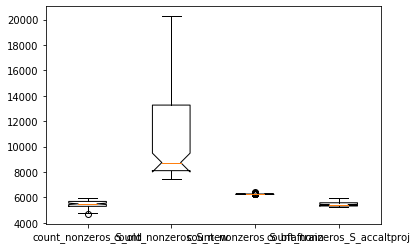

In [23]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [24]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.308749585103019e-20
fro_norm_L_new, fro_norm_L_old:  0.9398983981312639
mse_S_new, mse_S_old:  1.5530750381508534e-10
fro_norm_S_new, fro_norm_S_old:  8.374169471890889e-17
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0838724043916169e-35
fro_norm_L_new, fro_norm_L_accaltproj:  0.0005194770465944531
mse_S_new, mse_S_accaltproj:  4.526194127197014e-20
fro_norm_S_new, fro_norm_S_accaltproj:  4.125757605477576e-20
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  4.302915147495371e-145
fro_norm_L_new, fro_norm_L_bftrain:  6.082319324591236e-07
mse_S_new, mse_S_bftrain:  2.8323995770723524e-111
fro_norm_S_new, fro_norm_S_bftrain:  1.8452563681371553e-114
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


In [25]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  4.683247941888491e-28
fro_norm_L_new, fro_norm_L_old:  0.9717768405400161
mse_S_new, mse_S_old:  1.2493908922188923e-13
fro_norm_S_new, fro_norm_S_old:  1.249417364208798e-13
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  3.5305203920201575e-41
fro_norm_L_new, fro_norm_L_accaltproj:  8.270961556781322e-06
mse_S_new, mse_S_accaltproj:  1.0834813352086054e-14
fro_norm_S_new, fro_norm_S_accaltproj:  1.0834903813665504e-14
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  4.4708072699732176e-123
fro_norm_L_new, fro_norm_L_bftrain:  5.590430590881386e-10
mse_S_new, mse_S_bftrain:  2.8323507774774224e-91
fro_norm_S_new, fro_norm_S_bftrain:  2.832366926595243e-91
count_nonzeros_S_new, count_nonzeros_S_b

<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

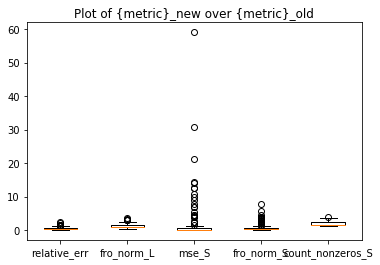

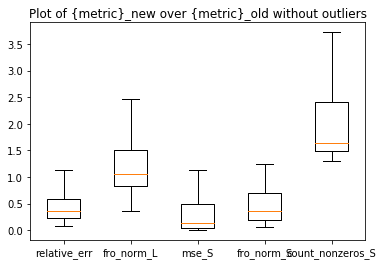

relative_err: 11/120 outliers
fro_norm_L: 5/120 outliers
mse_S: 25/120 outliers
fro_norm_S: 24/120 outliers
count_nonzeros_S: 1/120 outliers


In [16]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [17]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  4.683305434862443e-28
fro_norm_L:  0.971776818738672
mse_S:  1.2493923900818718e-13
fro_norm_S:  1.24942362600691e-13
count_nonzeros_S:  1.0


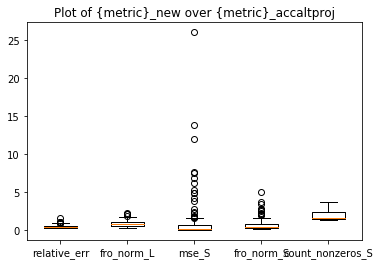

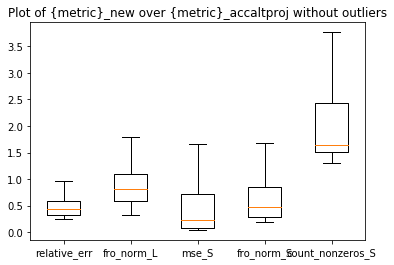

relative_err: 7/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 20/120 outliers
fro_norm_S: 12/120 outliers
count_nonzeros_S: 0/120 outliers


In [26]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [28]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  3.803230460286367e-46
fro_norm_L:  0.023449874735088503
mse_S:  0.7946888278922977
fro_norm_S:  0.0010775310514562922
count_nonzeros_S:  1.0


In [27]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  3.5305304350770935e-41
fro_norm_L:  8.270945504640284e-06
mse_S:  1.0834735765823668e-14
fro_norm_S:  1.0834947090704824e-14
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.003e-01; beta=8.820e-03

***results: better for L but worse for S***

In [57]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.3
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [58]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est2.append((L0, S0, M_true))

In [112]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=7, dataset=train_est2)

[Parameter containing:
tensor(6.999e-01, requires_grad=True), Parameter containing:
tensor(2.993e-02, requires_grad=True)]
Epoch 1/7 at cost=9.555678470718476e-11
[Parameter containing:
tensor(6.998e-01, requires_grad=True), Parameter containing:
tensor(2.986e-02, requires_grad=True)]
Epoch 1/7 at cost=9.48022632618617e-11
[Parameter containing:
tensor(6.997e-01, requires_grad=True), Parameter containing:
tensor(2.978e-02, requires_grad=True)]
Epoch 1/7 at cost=8.301932058474293e-11
[Parameter containing:
tensor(6.996e-01, requires_grad=True), Parameter containing:
tensor(2.971e-02, requires_grad=True)]
Epoch 1/7 at cost=9.484087820643694e-11
[Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(2.964e-02, requires_grad=True)]
Epoch 1/7 at cost=8.370344695141085e-11
[Parameter containing:
tensor(6.994e-01, requires_grad=True), Parameter containing:
tensor(2.957e-02, requires_grad=True)]
Epoch 1/7 at cost=1.0002142170062456e-10
[Parameter containing:

#### Evaluating unrolled network on train dataset

In [120]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

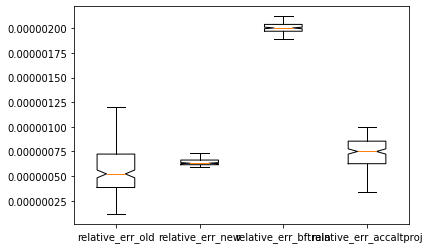

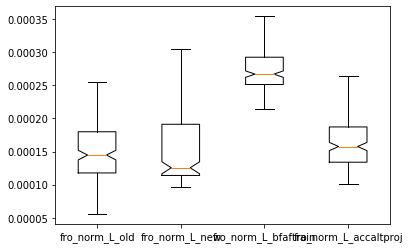

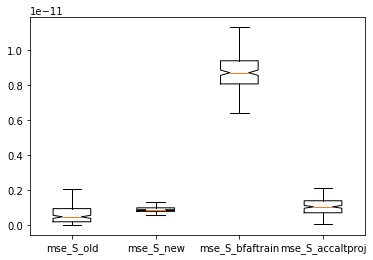

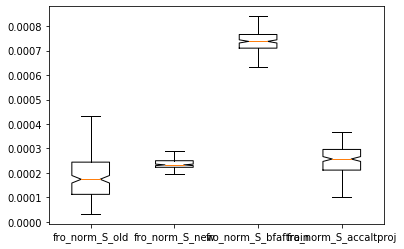

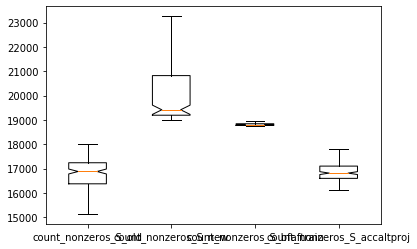

In [121]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [122]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  0.9999999999696964
fro_norm_L_new, fro_norm_L_old:  0.03797550459303913
mse_S_new, mse_S_old:  0.9293038167104971
fro_norm_S_new, fro_norm_S_old:  0.9293041908429649
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  8.551856447632138e-10
fro_norm_L_new, fro_norm_L_accaltproj:  0.014603438765356287
mse_S_new, mse_S_accaltproj:  0.5432224817304838
fro_norm_S_new, fro_norm_S_accaltproj:  0.5432332880061461
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  2.9003351785859456e-239
fro_norm_L_new, fro_norm_L_bftrain:  1.3805652636402451e-62
mse_S_new, mse_S_bftrain:  2.9505312965634785e-169
fro_norm_S_new, fro_norm_S_bftrain:  2.950605977837204e-169
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


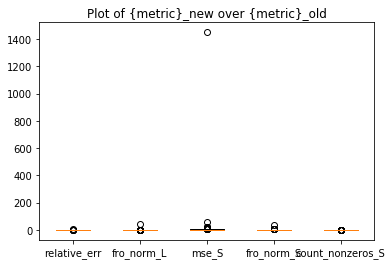

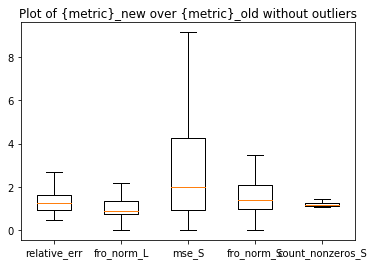

relative_err: 5/180 outliers
fro_norm_L: 18/180 outliers
mse_S: 18/180 outliers
fro_norm_S: 8/180 outliers
count_nonzeros_S: 10/180 outliers


In [123]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [124]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  0.9999999999696965
fro_norm_L:  0.03797548328193796
mse_S:  0.9293038067820505
fro_norm_S:  0.929304173316605
count_nonzeros_S:  1.0


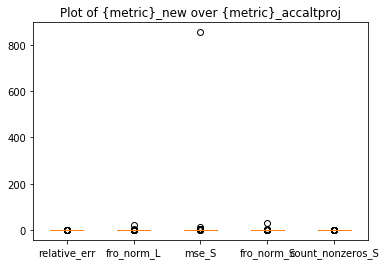

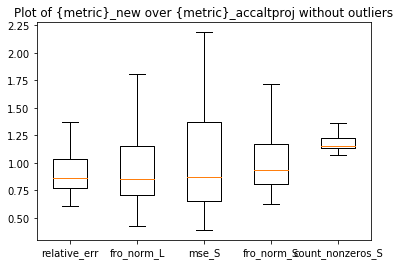

relative_err: 8/180 outliers
fro_norm_L: 12/180 outliers
mse_S: 16/180 outliers
fro_norm_S: 9/180 outliers
count_nonzeros_S: 17/180 outliers


In [125]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [126]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  8.551890464748065e-10
fro_norm_L:  0.014603424579108591
mse_S:  0.5432223754026282
fro_norm_S:  0.5432334378716293
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [113]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest2.append((L0, S0))

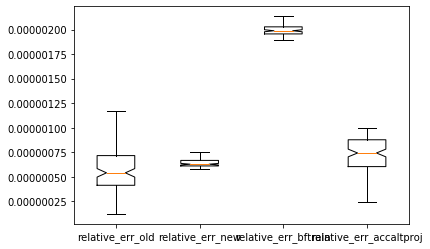

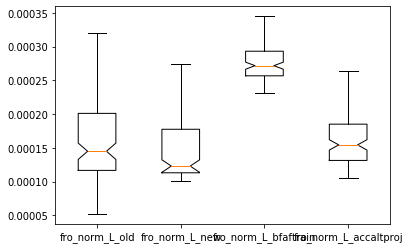

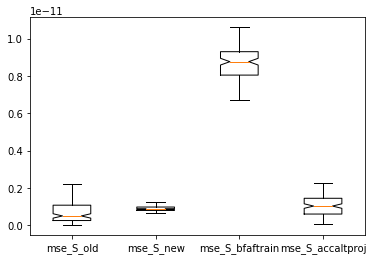

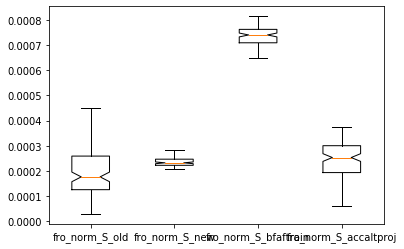

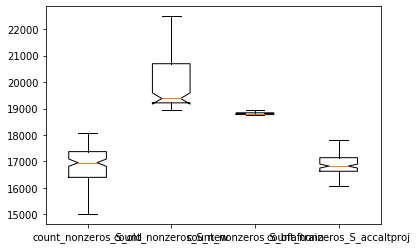

In [114]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [115]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  0.9999718095744808
fro_norm_L_new, fro_norm_L_old:  0.006045085757375364
mse_S_new, mse_S_old:  0.29004057586049997
fro_norm_S_new, fro_norm_S_old:  0.2900409646803383
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  0.0011590738494008457
fro_norm_L_new, fro_norm_L_accaltproj:  0.034544616074417424
mse_S_new, mse_S_accaltproj:  0.8480483315808888
fro_norm_S_new, fro_norm_S_accaltproj:  0.8480525064016962
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  2.1366807955872642e-160
fro_norm_L_new, fro_norm_L_bftrain:  1.5470382711418136e-45
mse_S_new, mse_S_bftrain:  7.011401135318898e-107
fro_norm_S_new, fro_norm_S_bftrain:  7.010461238650354e-107
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


<p style="color:blue;"> Unrolled have improvement over ircur for both L and S, and only improved over accaltproj for L. </p>

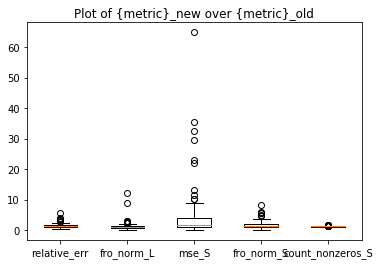

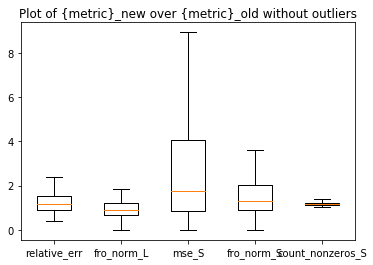

relative_err: 6/120 outliers
fro_norm_L: 11/120 outliers
mse_S: 10/120 outliers
fro_norm_S: 6/120 outliers
count_nonzeros_S: 11/120 outliers


In [116]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [117]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  0.9999718097491019
fro_norm_L:  0.006045087030112828
mse_S:  0.2900405510586523
fro_norm_S:  0.29004109228485486
count_nonzeros_S:  1.0


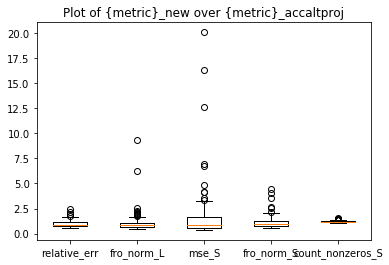

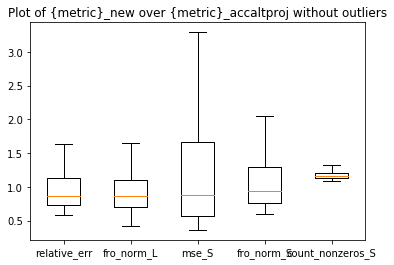

relative_err: 4/120 outliers
fro_norm_L: 11/120 outliers
mse_S: 10/120 outliers
fro_norm_S: 6/120 outliers
count_nonzeros_S: 19/120 outliers


In [118]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [119]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  0.0011590738054271116
fro_norm_L:  0.03454465484379647
mse_S:  0.8480483495561856
fro_norm_S:  0.8480526859359303
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj. </p>

### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=6.923e-01; beta=2.431e-02

***result: Same as the case when trained on accaltproj, S from unrolled isn't as good as accaltproj, but is better than ircur. L from unrolled isn't as good as ircur but better than accaltproj.***

In [74]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.01
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [75]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est3.append((L0, S0, M_true))

In [76]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=7e-04, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est3)

[Parameter containing:
tensor(6.997e-01, requires_grad=True), Parameter containing:
tensor(2.981e-02, requires_grad=True)]
Epoch 1/5 at cost=3.3919111963598425e-09
[Parameter containing:
tensor(6.994e-01, requires_grad=True), Parameter containing:
tensor(2.961e-02, requires_grad=True)]
Epoch 1/5 at cost=9.513740906186285e-10
[Parameter containing:
tensor(6.991e-01, requires_grad=True), Parameter containing:
tensor(2.939e-02, requires_grad=True)]
Epoch 1/5 at cost=7.374283128580572e-11
[Parameter containing:
tensor(6.988e-01, requires_grad=True), Parameter containing:
tensor(2.918e-02, requires_grad=True)]
Epoch 1/5 at cost=1.0192749977377957e-09
[Parameter containing:
tensor(6.986e-01, requires_grad=True), Parameter containing:
tensor(2.900e-02, requires_grad=True)]
Epoch 1/5 at cost=1.4612328236296435e-08
[Parameter containing:
tensor(6.983e-01, requires_grad=True), Parameter containing:
tensor(2.882e-02, requires_grad=True)]
Epoch 1/5 at cost=1.7242209049417312e-10
[Parameter contain

#### Evaluating unrolled network on train dataset

In [77]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

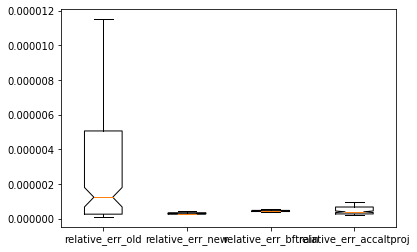

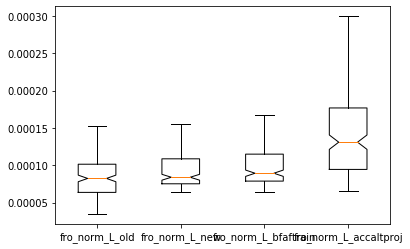

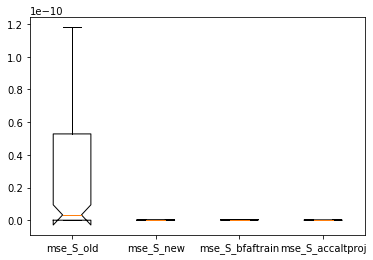

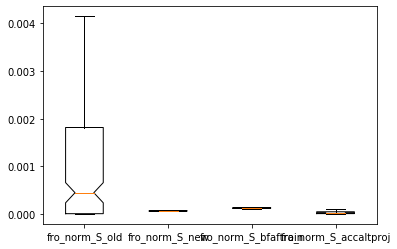

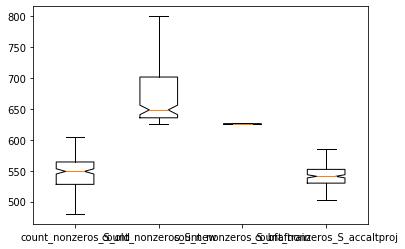

In [78]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [79]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  9.132924759761511e-14
fro_norm_L_new, fro_norm_L_old:  0.9943675314019101
mse_S_new, mse_S_old:  0.00040040848014805396
fro_norm_S_new, fro_norm_S_old:  2.8273936642426196e-13
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  4.0361944203564e-16
fro_norm_L_new, fro_norm_L_accaltproj:  8.492332911867244e-18
mse_S_new, mse_S_accaltproj:  0.0013133522090558517
fro_norm_S_new, fro_norm_S_accaltproj:  0.9565567660079244
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  1.0784889371827875e-51
fro_norm_L_new, fro_norm_L_bftrain:  0.015991484734975435
mse_S_new, mse_S_bftrain:  1.3710091618917214e-163
fro_norm_S_new, fro_norm_S_bftrain:  1.6678184595607673e-198
count_nonzeros_S_new, count_nonzeros_S_bftrain:  0.9999999999999744


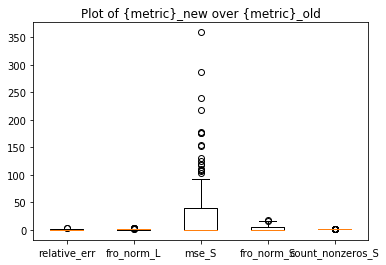

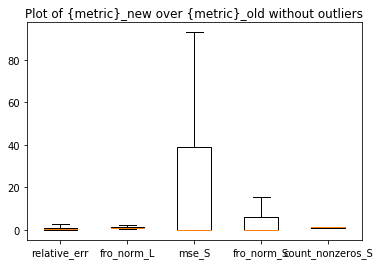

relative_err: 2/180 outliers
fro_norm_L: 7/180 outliers
mse_S: 17/180 outliers
fro_norm_S: 2/180 outliers
count_nonzeros_S: 17/180 outliers


In [80]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [81]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  1.4267360182964056e-24
fro_norm_L:  0.9999001542015836
mse_S:  7.0988462029162494e-09
fro_norm_S:  7.0988462029162494e-09
count_nonzeros_S:  1.0


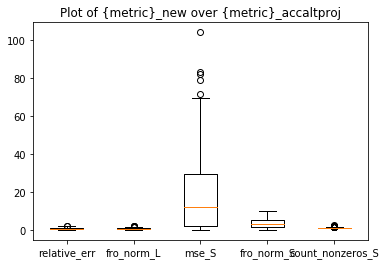

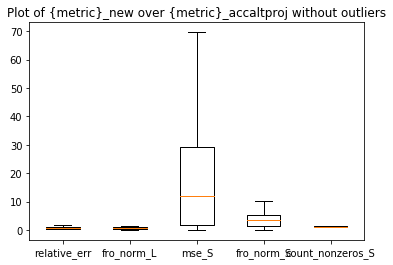

relative_err: 2/180 outliers
fro_norm_L: 6/180 outliers
mse_S: 5/180 outliers
fro_norm_S: 0/180 outliers
count_nonzeros_S: 21/180 outliers


In [82]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [83]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.3867864743452116e-07
fro_norm_L:  6.539370324774134e-15
mse_S:  1.0
fro_norm_S:  1.0
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [84]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest3.append((L0, S0))

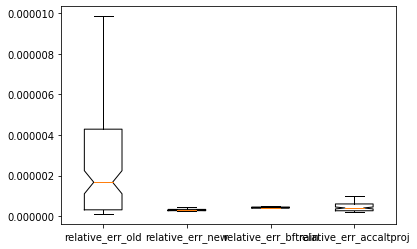

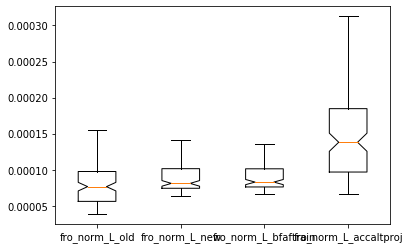

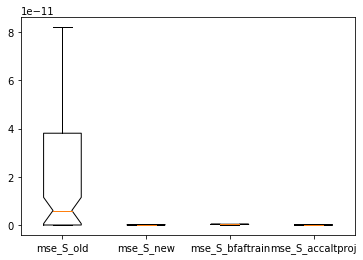

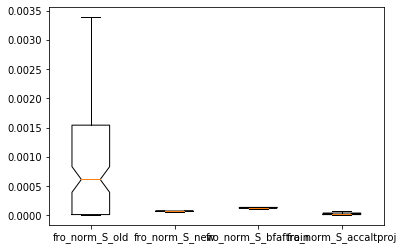

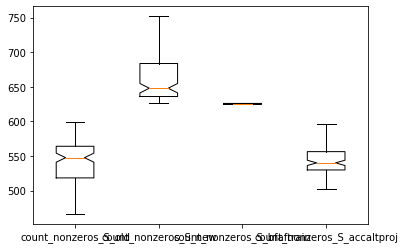

In [85]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [86]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.132781680905162e-10
fro_norm_L_new, fro_norm_L_old:  0.9929526747739235
mse_S_new, mse_S_old:  0.0003699631674299909
fro_norm_S_new, fro_norm_S_old:  3.206066823291466e-10
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  7.70917003215995e-12
fro_norm_L_new, fro_norm_L_accaltproj:  6.597084980837905e-16
mse_S_new, mse_S_accaltproj:  0.06753463786851172
fro_norm_S_new, fro_norm_S_accaltproj:  0.9983635760439963
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  4.293333014352137e-39
fro_norm_L_new, fro_norm_L_bftrain:  0.13093988831095604
mse_S_new, mse_S_bftrain:  3.1157734610679317e-111
fro_norm_S_new, fro_norm_S_bftrain:  1.1907831420010184e-137
count_nonzeros_S_new, count_nonzeros_S_bftrain:  0.9999999997682474


<p style="color:blue;"> L from unrolled is better than from AccAltproj but not IRCUR. S from unrolled is better than IRCUR but not AccAltproj. </p>

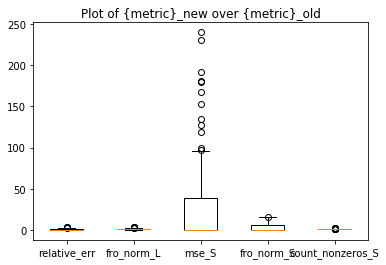

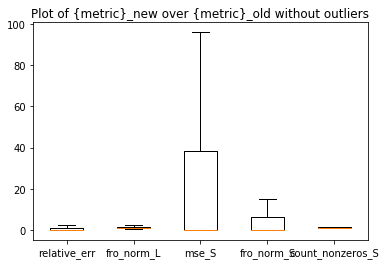

relative_err: 3/120 outliers
fro_norm_L: 5/120 outliers
mse_S: 12/120 outliers
fro_norm_S: 1/120 outliers
count_nonzeros_S: 8/120 outliers


In [87]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [88]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  4.126780613376051e-18
fro_norm_L:  0.9997880690964407
mse_S:  1.0090795320227222e-06
fro_norm_S:  1.0090795320227222e-06
count_nonzeros_S:  1.0


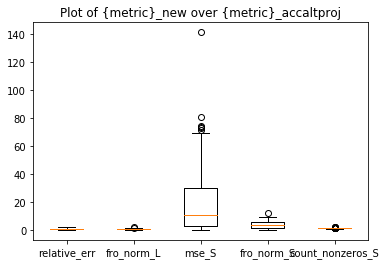

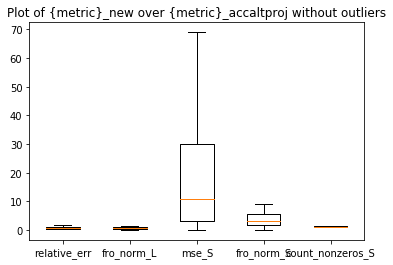

relative_err: 0/120 outliers
fro_norm_L: 2/120 outliers
mse_S: 6/120 outliers
fro_norm_S: 1/120 outliers
count_nonzeros_S: 14/120 outliers


In [89]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [90]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.6208133497120434e-06
fro_norm_L:  5.8616688998057405e-15
mse_S:  0.9999999999999987
fro_norm_S:  1.0
count_nonzeros_S:  1.0


<p style="color:blue;"> Same as the case when trained on accaltproj, S from unrolled isn't as good as accaltproj. </p>

### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=6.825e-01; beta=1.725e-02

***results: for S, mean and sd improved, but ratio _new/_old harder to interpret.***

In [91]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.1
c_true = 10
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [92]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est4.append((L0, S0, M_true))

In [93]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=5, dataset=train_est4)

[Parameter containing:
tensor(6.998e-01, requires_grad=True), Parameter containing:
tensor(2.991e-02, requires_grad=True)]
Epoch 1/5 at cost=3.80506078034859e-11
[Parameter containing:
tensor(6.997e-01, requires_grad=True), Parameter containing:
tensor(2.981e-02, requires_grad=True)]
Epoch 1/5 at cost=7.67137482010627e-12
[Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(2.971e-02, requires_grad=True)]
Epoch 1/5 at cost=1.6856786799746004e-11
[Parameter containing:
tensor(6.993e-01, requires_grad=True), Parameter containing:
tensor(2.960e-02, requires_grad=True)]
Epoch 1/5 at cost=8.430783848822898e-12
[Parameter containing:
tensor(6.991e-01, requires_grad=True), Parameter containing:
tensor(2.950e-02, requires_grad=True)]
Epoch 1/5 at cost=4.391702279615828e-12
[Parameter containing:
tensor(6.990e-01, requires_grad=True), Parameter containing:
tensor(2.939e-02, requires_grad=True)]
Epoch 1/5 at cost=3.557709335466619e-11
[Parameter containing:


#### Evaluating unrolled network on train dataset

In [94]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

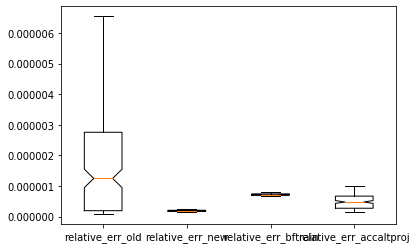

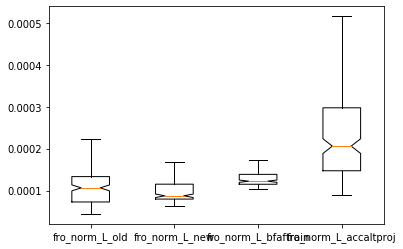

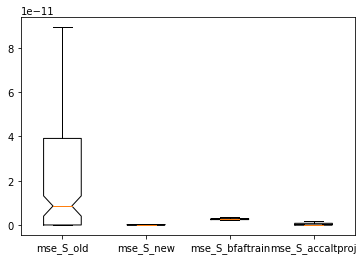

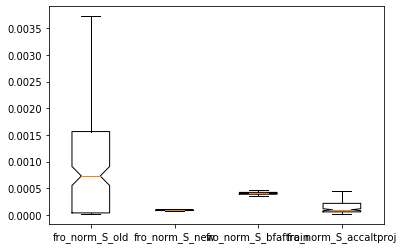

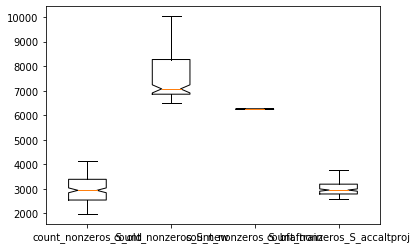

In [95]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [96]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.866771242352556e-20
fro_norm_L_new, fro_norm_L_old:  0.03809781814752554
mse_S_new, mse_S_old:  8.143745950135282e-10
fro_norm_S_new, fro_norm_S_old:  6.368304593028738e-20
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  3.3840591384899546e-38
fro_norm_L_new, fro_norm_L_accaltproj:  1.0988901419859223e-31
mse_S_new, mse_S_accaltproj:  1.1884404359759437e-10
fro_norm_S_new, fro_norm_S_accaltproj:  7.640939505864059e-10
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  2.001218293294023e-201
fro_norm_L_new, fro_norm_L_bftrain:  3.8203330660025394e-15
mse_S_new, mse_S_bftrain:  1.098577255159465e-163
fro_norm_S_new, fro_norm_S_bftrain:  1.9574990142856387e-192
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


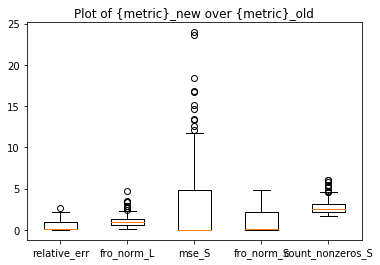

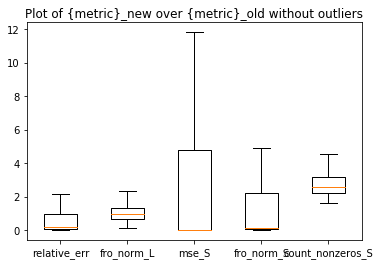

relative_err: 1/180 outliers
fro_norm_L: 10/180 outliers
mse_S: 11/180 outliers
fro_norm_S: 0/180 outliers
count_nonzeros_S: 10/180 outliers


In [97]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [98]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.2572203473427043e-31
fro_norm_L:  0.15862450094147457
mse_S:  9.662934226236274e-19
fro_norm_S:  9.662999268567481e-19
count_nonzeros_S:  1.0


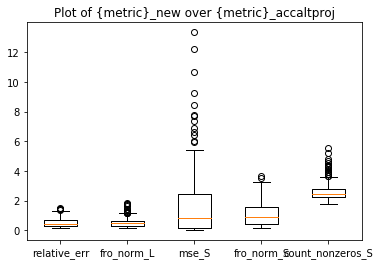

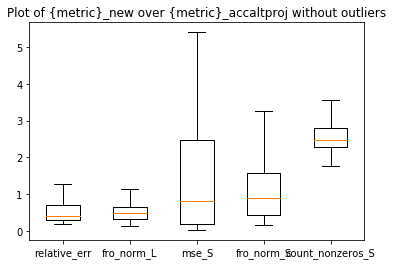

relative_err: 5/180 outliers
fro_norm_L: 13/180 outliers
mse_S: 13/180 outliers
fro_norm_S: 2/180 outliers
count_nonzeros_S: 20/180 outliers


In [99]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [100]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.2520510542268835e-51
fro_norm_L:  1.2454834969356944e-42
mse_S:  0.9999858908837729
fro_norm_S:  0.908568721570845
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [101]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest4.append((L0, S0))

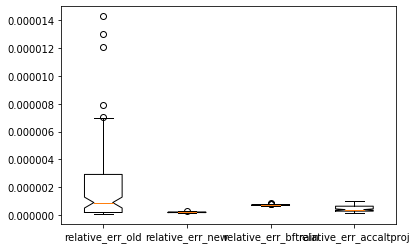

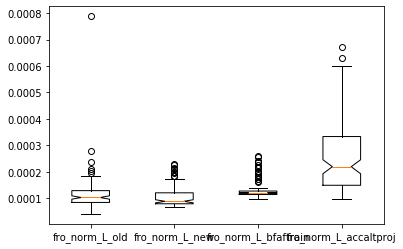

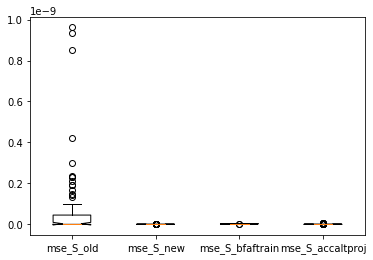

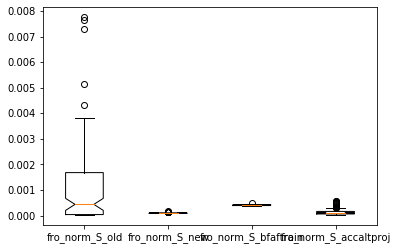

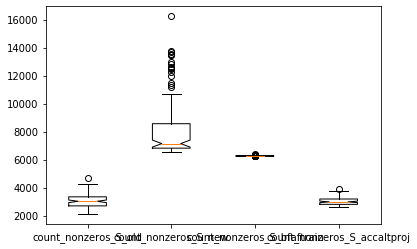

In [102]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [103]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  2.364152914227213e-11
fro_norm_L_new, fro_norm_L_old:  0.157129695538214
mse_S_new, mse_S_old:  4.186348259626492e-05
fro_norm_S_new, fro_norm_S_old:  6.676975234470575e-11
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.789822765158887e-23
fro_norm_L_new, fro_norm_L_accaltproj:  5.152549455588811e-24
mse_S_new, mse_S_accaltproj:  2.6614641251456106e-05
fro_norm_S_new, fro_norm_S_accaltproj:  0.00010196792789831406
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  3.680960948897625e-132
fro_norm_L_new, fro_norm_L_bftrain:  5.512815008270265e-07
mse_S_new, mse_S_bftrain:  1.8726506400274024e-110
fro_norm_S_new, fro_norm_S_bftrain:  5.187525024636969e-127
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

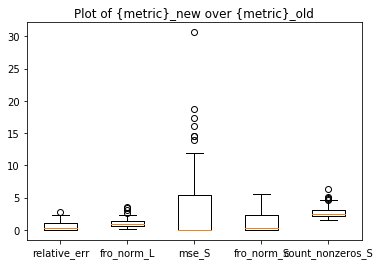

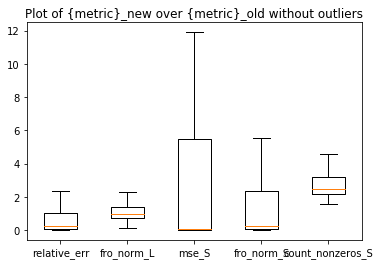

relative_err: 1/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 7/120 outliers
fro_norm_S: 0/120 outliers
count_nonzeros_S: 5/120 outliers


In [109]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [111]:
print("P-values from test of mean with H1: _new/_old < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  3.025178285027989e-11
fro_norm_L:  0.967724240301834
mse_S:  0.9999946958446339
fro_norm_S:  0.8661652740477674
count_nonzeros_S:  1.0


In [105]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.39415780337202e-18
fro_norm_L:  0.2485170637534238
mse_S:  3.283002884978786e-10
fro_norm_S:  3.283033563873607e-10
count_nonzeros_S:  1.0


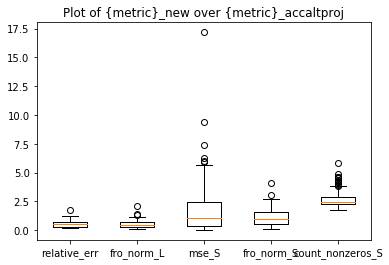

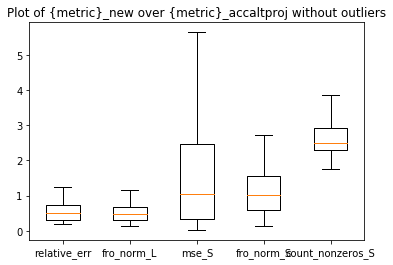

relative_err: 1/120 outliers
fro_norm_L: 3/120 outliers
mse_S: 6/120 outliers
fro_norm_S: 2/120 outliers
count_nonzeros_S: 13/120 outliers


In [106]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [107]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.8910339193089435e-35
fro_norm_L:  8.95423568513112e-37
mse_S:  0.9999059337019293
fro_norm_S:  0.9813618814576334
count_nonzeros_S:  1.0


In [108]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  8.172903924257691e-31
fro_norm_L:  2.284762028777857e-33
mse_S:  0.0673726551750879
fro_norm_S:  0.06737272216775513
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>